# 06 Computing voxel-vise overlap between tumour segments (segment_glioma) and anatomical segments (SynthSeg+)


Kernel: `glioma-loc-long` on MacOS (--> segment-glioma (Python 3.11.9)`)

Arvid Lundervold & Marianne Hannisdal  

Last updated: **2025-03-13**  

### Import libraries we will use

In [1]:
# Import libraries
import os
import os.path as op
import glob
import shutil
import subprocess as subp
import pathlib
import platform
import shutil
import IPython
from datetime import date
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import nibabel as nib
from nibabel.viewers import OrthoSlicer3D
import nilearn
from nilearn import plotting
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import pickle
import pydicom
from pydicom import dcmread
# import imageio
import imageio.v2 as imageio
from scipy import ndimage
from scipy.ndimage import zoom
from scipy.ndimage import distance_transform_edt

%matplotlib inline
home = os.path.expanduser('~')            # To make a path to local home directory
                       
warnings.filterwarnings('ignore')         # To ignore warnings

In [2]:
print(f'platform: {platform.platform()}')
print(f'python version: {platform.python_version()}')
print(f'pydicom version: {pydicom.__version__}')
print(f'nibabel version: {nib.__version__}')
print(f'nilearn version: {nilearn.__version__}')
print(f'pandas version: {pd.__version__}')
print(f'numpy version: {np.__version__}')
print(f'seaborn version: {sns.__version__}')

platform: Linux-6.8.0-45-generic-x86_64-with-glibc2.39
python version: 3.11.9
pydicom version: 2.4.4
nibabel version: 5.2.1
nilearn version: 0.10.4
pandas version: 2.2.2
numpy version: 1.26.4
seaborn version: 0.13.2


In [3]:
verbose = True

**Check your platform for running this notebook (modify as needed):**

In [32]:
SITE = '10'   

if platform.system() == 'Darwin':
    print(f'OK, you are running on MacOS ({platform.version()})')
    PRJ_DIR = f'{home}/prj/glioma-recurrence'
    TREE = '/usr/local/bin/tree'          # MacOS (brew install tree)
    MacOS = True
if platform.system() == 'Linux':
    print(f'OK, you are running on Linux ({platform.version()})')
    PRJ_DIR = f"{os.path.expanduser('~')}/prj/glioma_recurrence/glioma_recurrence/data"
    TREE = '/usr/bin/tree -L 1'
    DU = '/usr/bin/du -h -d 2'
    lut_path = '/usr/local/freesurfer/luts/FreeSurferColorLUT.txt'

REGISTERED = f'{PRJ_DIR}/{SITE}/registered'
SEGMENT_GLIOMA = f'{PRJ_DIR}/{SITE}/segment_glioma'
SYNTHSEG = f'{PRJ_DIR}/{SITE}/synthseg'
RESULTS = f'{PRJ_DIR}/{SITE}/results'
easyreg_dir = f'{PRJ_DIR}/{SITE}/easyreg_2'

Currdir = os.getcwd()
print(Currdir)

OK, you are running on Linux (#45~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Wed Sep 11 15:25:05 UTC 2)
/home/marianne/prj/glioma_recurrence/glioma_recurrence/nbs/MHH_scripts


In [33]:
exams_list_site = sorted([x for x in next(os.walk(easyreg_dir))[1]])
exams_list_site

['10_045_20150103', '10_045_20150424']

### Definition of 'get_patient_info' from the exams_list_site
Enabling patients pair-wise (primary and recurrent) analyis

In [34]:
# Function to extract information based on the patient number
def get_patient_info(patient_num, exam_list):
    # Calculate the starting index for the patient (each patient has 2 exams)
    start_index = (patient_num - 1) * 2
    
    # Extract the two lines corresponding to the patient
    patient_exam1 = exam_list[start_index]
    patient_exam2 = exam_list[start_index + 1]
    
    # Split the data to get site, subj, and date
    site1, subj1, date1 = patient_exam1.split('_')
    site2, subj2, date2 = patient_exam2.split('_')
    
    # Ensure the site and subject are the same for both dates
    if site1 == site2 and subj1 == subj2:
        return site1, subj1, date1, date2
    else:
        return "Error: Data mismatch between the two exams for this patient"

### Definition of what synthseg-elements that makes up the lobes and hemispheres

In [35]:
def get_lobe_mapping():
    return {
        'frontal_left': [
            1003, 1012, 1014, 1018, 1019, 1020, 1024, 1027, 1028, 1032, 
            3003, 3012, 3014, 3018, 3019, 3020, 3024, 3027, 3028, 3032
        ],
        'frontal_right': [
            2003, 2012, 2014, 2018, 2019, 2020, 2024, 2027, 2028, 2032,
            4003, 4012, 4014, 4018, 4019, 4020, 4024, 4027, 4028, 4032
        ],
        'parietal_left': [
            1008, 1017, 1022, 1025, 1029, 1031, 
            3008, 3017, 3022, 3025, 3029, 3031
        ],
        'parietal_right': [
            2008, 2017, 2022, 2025, 2029, 2031, 
            4008, 4017, 4022, 4025, 4029, 4031
        ],
        'temporal_left': [
            1001, 1006, 1007, 1009, 1015, 1016, 1030, 1033, 1034, 
            17, 18, 3007, 3015, 3016, 3030, 3033, 3034
        ],
        'temporal_right': [
            2001, 2006, 2007, 2009, 2015, 2016, 2030, 2033, 2034,
            53, 54, 4007, 4015, 4016, 4030, 4033, 4034
        ],
        'occipital_left': [
            1005, 1011, 1013, 1021,
            3005, 3011, 3013, 3021
        ],
        'occipital_right': [
            2005, 2011, 2013, 2021, 
            4005, 4011, 4013, 4021
        ],
        'limbic_left': [
            1002, 1010, 1023, 1026, 1035
        ],
        'limbic_right': [
            2002, 2010, 2023, 2026, 2035
        ],
        'subcortical_left': [
            11, 12, 13, 26, 10, 28
        ],
        'subcortical_right': [
            50, 51, 52, 58, 49, 60
        ],
        'brainstem_and_cerebellum': [
            16, 7, 8, 46, 47
        ],
        'ventricles': [
            4, 5, 14, 15, 43, 44
        ],
        'corpus_callosum': [
        ]
    }

def get_hemisphere_mapping():
    return {
        'hemisphere_left': [
            1003, 1012, 1014, 1018, 1019, 1020, 1024, 1027, 1028, 1032,
            1008, 1017, 1022, 1025, 1029, 1031,
            1001, 1006, 1007, 1009, 1015, 1016, 1030, 1033, 1034,
            1005, 1011, 1013, 1021,
            1002, 1010, 1023, 1026, 1035,
            11, 12, 13, 26, 10, 28, 17, 18, 3, 4, 2,
            3201, 3203, 3205, 3205
        ],
        'hemisphere_right': [
            2003, 2012, 2014, 2018, 2019, 2020, 2024, 2027, 2028, 2032,
            2008, 2017, 2022, 2025, 2029, 2031,
            2001, 2006, 2007, 2009, 2015, 2016, 2030, 2033, 2034,
            2005, 2011, 2013, 2021, 
            2002, 2010, 2023, 2026, 2035,
            50, 51, 52, 58, 49, 60, 53, 54, 41, 43, 44,
            4201, 4203, 4205, 4205
        ],
        'central': [
            14, 15, 16, 24
        ]
    }

### Definition of 'lut_path', 'check_and_resample_if_needed', and 'compute_region_level_overlap_mm3'

**'lut_path'** states the directory path to the Freesurfer look-up-table

**'check_and_resample_if_needed'** uses the primary CT1 as template for voxel dimensions.
- The zoom factors are calculated as: target_size/current_size for each dimension
- For CT1 images, cubic interpolation (order=3) is used, which:
    - Considers neighboring voxels' intensities
    - Creates smooth transitions
    - Can generate new intensity values through interpolation
    - Works well for continuous data like MRi signal intensity-values
- For segmentation resampling Nearest Neighbor interpolation (order=0) is used, which:
    - Takes the value of the closest voxel
    - Does NOT interpolate between label values
    - Preserves the exact label values (1, 2, 3 etc.)

**'compute_region_level_overlap_mm3'** calculates how much tumor volume 'CE_core', 'NE' and 'Total' are overlapping with each lobe and hemisphere in primary and recurrent CT1, respectively

In [36]:
# Load LUT and perform analysis
def load_freesurfer_lut(lut_path):
    lut = {}
    with open(lut_path, 'r') as f:
        for line in f:
            if not line.startswith('#') and line.strip():
                parts = line.split()
                if len(parts) >= 2:
                    lut[int(parts[0])] = parts[1]
    return lut

# Resampling function in case of dimension mismatch
def check_and_resample_if_needed(reference_img, img_to_check, is_segmentation=False):
    """
    Check if resampling is needed and perform if necessary
    
    Parameters:
    reference_img: nibabel image object (template)
    img_to_check: nibabel image object (image to potentially resample)
    is_segmentation: boolean, whether the image is a segmentation
    
    Returns:
    numpy array of image data in reference space
    """
    reference_shape = reference_img.shape
    check_shape = img_to_check.shape
    
    if check_shape != reference_shape:
        print(f"\nDimension mismatch detected:")
        print(f"Reference shape: {reference_shape}")
        print(f"Current shape: {check_shape}")
        print("Resampling required...")
        
        # Calculate zoom factors
        zoom_factors = [t/s for s, t in zip(check_shape, reference_shape)]
        
        # Use nearest neighbor for segmentations, linear for other images
        order = 0 if is_segmentation else 3
        interpolation_type = 'nearest neighbor' if is_segmentation else 'linear'
        print(f"Using {interpolation_type} interpolation")
        print(f"Zoom factors: {zoom_factors}")
        
        # Perform resampling
        return zoom(img_to_check.get_fdata(), zoom_factors, order=order)
    else:
        print(f"\nNo resampling needed - dimensions match")
        return img_to_check.get_fdata()



### Definition of analyze_tumor_overlap
States how the function should be executed

In [37]:
import os
import pandas as pd
import nibabel as nib
import numpy as np
from scipy.ndimage import zoom
from datetime import datetime
import gc

In [38]:
def compute_region_level_overlap_mm3(tumor_seg_file, synthseg_file, wm_lobes_file, lut, region_mapping):
    """
    Compute region-level overlaps using both synthseg and WM lobe labels.
    """
    # Load images
    tumor_seg = nib.load(tumor_seg_file)
    synthseg = nib.load(synthseg_file)  # Reference space
    wm_lobes = nib.load(wm_lobes_file)
    
    # Resample tumor seg to synthseg space if needed
    tumor_data = check_and_resample_if_needed(synthseg, tumor_seg, is_segmentation=True)
    
    # Load synthseg and wm_lobes data
    synthseg_data = synthseg.get_fdata()
    wm_lobes_data = wm_lobes.get_fdata()
    
    # Round WM lobe labels to nearest integer to handle floating point variations
    wm_lobes_data = np.round(wm_lobes_data)
    
    # Get voxel dimensions from synthseg (reference space)
    voxel_dims = synthseg.header.get_zooms()
    voxel_volume = np.prod(voxel_dims)
    
    # Create tumor component masks
    tumor_masks = {
        'CE_core': (tumor_data == 3) | (tumor_data == 2),
        'NE': tumor_data == 1,
        'Total': tumor_data > 0
    }
    
    # Calculate total tumor volumes
    total_volumes = {
        component: np.sum(mask) * voxel_volume 
        for component, mask in tumor_masks.items()
    }
    
    
    
    # Create masks for each region
    region_masks = {}
    for region, structures in region_mapping.items():
        region_mask = np.zeros_like(synthseg_data, dtype=bool)
        
        # Create mapping dictionaries for WM lobe labels
    left_wm_lobes = {
        'frontal': 3201,
        'parietal': 3206,
        'temporal': 3205,
        'occipital': 3204,
        'cingulate': 3203,
        'insula': 3207
    }
    
    right_wm_lobes = {
        'frontal': 4201,
        'parietal': 4206,
        'temporal': 4205,
        'occipital': 4204,
        'cingulate': 4203,
        'insula': 4207
    }
    
    # Create region masks
    region_masks = {}
    for region, structures in region_mapping.items():
        region_mask = np.zeros_like(synthseg_data, dtype=bool)
        
        # Handle regular synthseg labels
        for structure in structures:
            if isinstance(structure, (int, np.integer)):
                region_mask |= (np.round(synthseg_data) == structure)
        
        # Add appropriate WM lobe labels based on region name
        if 'left' in region.lower():
            for lobe_name, lobe_label in left_wm_lobes.items():
                if lobe_name in region.lower():
                    region_mask |= (np.round(wm_lobes_data) == lobe_label)
                    # If this is a WM region, also include synthseg's general WM label
                    if any(s == 2 for s in structures):  # Left WM in synthseg
                        region_mask |= ((np.round(synthseg_data) == 2) & 
                                      (np.round(wm_lobes_data) == lobe_label))
        
        elif 'right' in region.lower():
            for lobe_name, lobe_label in right_wm_lobes.items():
                if lobe_name in region.lower():
                    region_mask |= (np.round(wm_lobes_data) == lobe_label)
                    # If this is a WM region, also include synthseg's general WM label
                    if any(s == 41 for s in structures):  # Right WM in synthseg
                        region_mask |= ((np.round(synthseg_data) == 41) & 
                                      (np.round(wm_lobes_data) == lobe_label))
        
        region_masks[region] = region_mask
    
    # Compute overlaps and track assignment
    overlaps_mm3 = {}
    assigned_voxels = {
        component: np.zeros_like(mask, dtype=bool)
        for component, mask in tumor_masks.items()
    }
    
    # Calculate overlaps for each region
    for region, mask in region_masks.items():
        region_overlaps = {}
        for component, tumor_mask in tumor_masks.items():
            overlap = tumor_mask & mask
            assigned_voxels[component] |= overlap
            region_overlaps[component] = np.sum(overlap) * voxel_volume
        
        overlaps_mm3[region] = region_overlaps
    
    # Check for unassigned voxels
    for component, tumor_mask in tumor_masks.items():
        unassigned = tumor_mask & ~assigned_voxels[component]
        
        if np.any(unassigned):
            print(f"\nWARNING: Found unassigned {component} voxels!")
            unassigned_volume = np.sum(unassigned) * voxel_volume
            total_volume = total_volumes[component]
            percent_unassigned = (unassigned_volume / total_volume) * 100
            print(f"Unassigned volume: {unassigned_volume:.2f} mm³ ({percent_unassigned:.2f}% of total)")
            
            # Get labels of unassigned locations
            unassigned_synthseg_labels = np.unique(np.round(synthseg_data[unassigned]))
            unassigned_wm_labels = np.unique(np.round(wm_lobes_data[unassigned]))
            
            print("SynthSeg labels in unassigned locations:")
            for label in unassigned_synthseg_labels:
                if int(label) in lut:
                    print(f"Label {int(label)}: {lut[int(label)]}")
                else:
                    print(f"Label {int(label)}: Unknown")
                    
            print("\nWM lobe labels in unassigned locations:")
            for label in unassigned_wm_labels:
                print(f"Label {int(label)}")
    
    # Add total volumes and assignment stats
    overlaps_mm3['total_volumes'] = total_volumes
    overlaps_mm3['assignment_stats'] = {
        component: {
            'assigned_percent': (np.sum(assigned_voxels[component]) * voxel_volume / total_volumes[component] * 100)
            if total_volumes[component] > 0 else 100.0
        }
        for component in tumor_masks.keys()
    }

    return overlaps_mm3

In [39]:
def compute_overall_change(primary, recurrent):
    """
    Compute overall change between primary and recurrent measurements.
    Handles the new dictionary structure that includes total_volumes.
    """
    # Remove non-region keys like 'total_volumes' and 'assignment_stats'
    region_keys = [k for k in primary.keys() if k not in ['total_volumes', 'assignment_stats']]
    
    # Create vectors for comparison
    primary_vec = np.array([primary[region]['Total'] for region in region_keys])
    recurrent_vec = np.array([recurrent[region]['Total'] for region in region_keys])

    return np.linalg.norm(recurrent_vec - primary_vec)


In [40]:
def validate_tumor_volume_assignment(tumor_seg_path, lobe_overlaps):
    """
    Validate that all tumor voxels are accounted for in the lobe overlaps.
    
    Args:
        tumor_seg_path: path to tumor segmentation file
        lobe_overlaps: dictionary containing overlap volumes and metadata
        
    Returns:
        dict: Validation results with percentages and volumes
    """
    # Load tumor segmentation and compute original volumes
    tumor_img = nib.load(tumor_seg_path)
    tumor_data = tumor_img.get_fdata()
    voxel_volume = np.prod(tumor_img.header.get_zooms())
    
    # Calculate original tumor volumes
    original_volumes = {
        'CE_core': np.sum((tumor_data == 2) | (tumor_data == 3)) * voxel_volume,
        'NE': np.sum(tumor_data == 1) * voxel_volume,
        'Total': np.sum(tumor_data > 0) * voxel_volume
    }
    
    # Extract only the region dictionaries (exclude metadata keys)
    region_keys = [k for k in lobe_overlaps.keys() 
                  if k not in ['total_volumes', 'assignment_stats']]
    
    # Sum up the overlaps across all regions
    overlap_sums = {
        'CE_core': sum(lobe_overlaps[region]['CE_core'] for region in region_keys),
        'NE': sum(lobe_overlaps[region]['NE'] for region in region_keys),
        'Total': sum(lobe_overlaps[region]['Total'] for region in region_keys)
    }
    
    # Calculate coverage percentages and unassigned volumes
    coverage = {
        component: {
            'original_volume': original_volumes[component],
            'assigned_volume': overlap_sums[component],
            'coverage_percent': (overlap_sums[component] / original_volumes[component] * 100) 
                              if original_volumes[component] > 0 else 100.0,
            'unassigned_volume': original_volumes[component] - overlap_sums[component]
        }
        for component in ['CE_core', 'NE', 'Total']
    }
    
    # Print validation results
    print("\nTumor Volume Assignment Validation")
    print("="*50)
    for component in ['CE_core', 'NE', 'Total']:
        print(f"\n{component}:")
        print(f"Original volume: {coverage[component]['original_volume']:.2f} mm³")
        print(f"Assigned volume: {coverage[component]['assigned_volume']:.2f} mm³")
        print(f"Coverage: {coverage[component]['coverage_percent']:.2f}%")
        
        if coverage[component]['unassigned_volume'] > 0:
            print(f"WARNING: {coverage[component]['unassigned_volume']:.2f} mm³ unassigned!")
        elif coverage[component]['unassigned_volume'] < 0:
            print(f"WARNING: {abs(coverage[component]['unassigned_volume']):.2f} mm³ over-assigned!")
            print("This might indicate overlapping region definitions.")
    
    return coverage

In [41]:
def analyze_tumor_overlap(primary_seg_path, recurrent_seg_path,
                         primary_synthseg_path, recurrent_synthseg_path,
                         primary_wm_lobes_path, recurrent_wm_lobes_path,
                         lut_path):
    """
    Analyze tumor overlap between primary and recurrent scans.
    Uses synthseg as the reference space for all analyses.
    """
    # Load FreeSurfer LUT and mappings
    lut = load_freesurfer_lut(lut_path)
    lobe_mapping = get_lobe_mapping()
    hemisphere_mapping = get_hemisphere_mapping()
    
    # Verify all files exist before processing
    for path in [primary_seg_path, recurrent_seg_path,
                 primary_synthseg_path, recurrent_synthseg_path,
                 primary_wm_lobes_path, recurrent_wm_lobes_path]:
        if not os.path.exists(path):
            raise FileNotFoundError(f"Required file not found: {path}")
    
    # Load primary synthseg to check its dimensions
    primary_synthseg = nib.load(primary_synthseg_path)
    primary_synthseg_dims = primary_synthseg.header.get_zooms()
    print(f"\nReference space (primary synthseg) dimensions: {primary_synthseg_dims}")
    
    # Perform lobe-level analysis
    primary_lobe_overlaps = compute_region_level_overlap_mm3(
        tumor_seg_file=primary_seg_path,
        synthseg_file=primary_synthseg_path,  # Used as reference
        wm_lobes_file=primary_wm_lobes_path,
        lut=lut,
        region_mapping=lobe_mapping
    )
    
    # Load recurrent synthseg to verify dimensions match
    recurrent_synthseg = nib.load(recurrent_synthseg_path)
    if recurrent_synthseg.header.get_zooms() != primary_synthseg_dims:
        print("\nWARNING: Recurrent synthseg dimensions differ from primary!")
        print(f"Primary: {primary_synthseg_dims}")
        print(f"Recurrent: {recurrent_synthseg.header.get_zooms()}")
    
    recurrent_lobe_overlaps = compute_region_level_overlap_mm3(
        tumor_seg_file=recurrent_seg_path,
        synthseg_file=recurrent_synthseg_path,  # Used as reference
        wm_lobes_file=recurrent_wm_lobes_path,
        lut=lut,
        region_mapping=lobe_mapping
    )
    
    # Similarly for hemisphere analysis...
    primary_hemisphere_overlaps = compute_region_level_overlap_mm3(
        tumor_seg_file=primary_seg_path,
        synthseg_file=primary_synthseg_path,  # Used as reference
        wm_lobes_file=primary_wm_lobes_path,
        lut=lut,
        region_mapping=hemisphere_mapping
    )
    
    recurrent_hemisphere_overlaps = compute_region_level_overlap_mm3(
        tumor_seg_file=recurrent_seg_path,
        synthseg_file=recurrent_synthseg_path,  # Used as reference
        wm_lobes_file=recurrent_wm_lobes_path,
        lut=lut,
        region_mapping=hemisphere_mapping
    )
    # Compute changes
    lobe_changes = {lobe: {component: recurrent_lobe_overlaps[lobe][component] - primary_lobe_overlaps[lobe][component] 
                           for component in ['CE_core', 'NE', 'Total']} 
                    for lobe in lobe_mapping}
    hemisphere_changes = {hemi: {component: recurrent_hemisphere_overlaps[hemi][component] - primary_hemisphere_overlaps[hemi][component] 
                                 for component in ['CE_core', 'NE', 'Total']} 
                          for hemi in hemisphere_mapping}
 
    lobe_overall_change = compute_overall_change(primary_lobe_overlaps, recurrent_lobe_overlaps)
    hemi_overall_change = compute_overall_change(primary_hemisphere_overlaps, recurrent_hemisphere_overlaps)
    
        # Add validation
    print("\nValidating primary tumor assignment:")
    primary_validation = validate_tumor_volume_assignment(primary_seg_path, primary_lobe_overlaps)
    
    print("\nValidating recurrent tumor assignment:")
    recurrent_validation = validate_tumor_volume_assignment(recurrent_seg_path, recurrent_lobe_overlaps)
    
    return {
        'primary_lobe_overlaps': primary_lobe_overlaps,
        'recurrent_lobe_overlaps': recurrent_lobe_overlaps,
        'lobe_changes': lobe_changes,
        'lobe_overall_change': lobe_overall_change,
        'primary_hemisphere_overlaps': primary_hemisphere_overlaps,
        'recurrent_hemisphere_overlaps': recurrent_hemisphere_overlaps,
        'hemisphere_changes': hemisphere_changes,
        'hemisphere_overall_change': hemi_overall_change,
        'volume_validation': {
            'primary': primary_validation,
            'recurrent': recurrent_validation
        }
    }

## Execution of looping analysis and writing tumor compartment overlap (mm3) to CSV: 
'{site}_tumor_overlap_WMlobes_NEW_SR.csv'

In [43]:
def process_patient_batch(exams_list_site, RESULTS_overall, lut_path):
    """
    Process all patients in the exam list with error handling and CSV management
    """
    # Create error log file name with timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    error_log = os.path.join(RESULTS_overall, f'processing_errors_{timestamp}.log')
    
    # Create results directory if it doesn't exist
    os.makedirs(RESULTS_overall, exist_ok=True)
    
    # Path for the summary CSV file
    summary_file = os.path.join(RESULTS_overall, f'{SITE}_tumor_overlap_WMlobes_NEW_SR__.csv')
    
    # Process each patient
    for patient_num in range(1, len(exams_list_site)//2 + 1):
        try:
            # Get patient info
            site, subj, date1, date2 = get_patient_info(patient_num, exams_list_site)
            if site is None:
                raise ValueError(f"Could not get valid patient info")
            
            print(f"\nProcessing patient {patient_num}: {site}_{subj}")
            
            # Create file lists
            X1_list = [f'{site}_{subj}_{date1}_CT1_coreg']
            y1_list = [
                f'segmentation_native_{site}_{subj}_{date1}_CT1_coreg',
                f'{site}_{subj}_{date1}_CT1_SynthSR_synthseg_parc_robust.nii.gz',
                f'{site}_{subj}_{date1}_CT1_SR_synthetic_wm_lobes.nii.gz'
            ]
            
            X2_list = [f'{site}_{subj}_{date2}_CT1_coreg_registered_to_{site}_{subj}_{date1}']
            y2_list = [
                f'segmentation_native_{site}_{subj}_{date2}_CT1_coreg_registered_to_{site}_{subj}_{date1}',
                f'{site}_{subj}_{date2}_CT1_SynthSR_synthseg_parc_robust_registered_to_{site}_{subj}_{date1}',
                f'{site}_{subj}_{date2}_CT1_SR_synthetic_wm_lobes_registered_to_{site}_{subj}_{date1}'
            ]
            
            # Add .nii.gz extension
            X1_list = [f'{x}.nii.gz' for x in X1_list]
            y1_list = [f'{y}.nii.gz' if not y.endswith('.nii.gz') else y for y in y1_list]
            X2_list = [f'{x}.nii.gz' for x in X2_list]
            y2_list = [f'{y}.nii.gz' if not y.endswith('.nii.gz') else y for y in y2_list]
            
            # Process the patient
            EXAM_DIR = f'{REGISTERED}/{SITE}_{subj}'
            results = analyze_tumor_overlap(
                primary_seg_path=f'{EXAM_DIR}/{y1_list[0]}',
                recurrent_seg_path=f'{EXAM_DIR}/{y2_list[0]}',
                primary_synthseg_path=f'{EXAM_DIR}/{y1_list[1]}',
                recurrent_synthseg_path=f'{EXAM_DIR}/{y2_list[1]}',
                primary_wm_lobes_path=f'{EXAM_DIR}/{y1_list[2]}',    # Add these
                recurrent_wm_lobes_path=f'{EXAM_DIR}/{y2_list[2]}',  # Add these
                lut_path=lut_path
            )
            
            # Prepare summary data
            summary_data = {
                'Subject': f"{site}_{subj}",
                'Lobe_Overall_Change': results['lobe_overall_change'],
                'Hemisphere_Overall_Change': results['hemisphere_overall_change']
            }
            
            # Add lobe-specific data
            for lobe, changes in results['lobe_changes'].items():
                for component in ['CE_core', 'NE', 'Total']:
                    summary_data[f'{lobe}_{component}_Change'] = changes[component]
                    summary_data[f'{lobe}_{component}_Primary'] = results['primary_lobe_overlaps'][lobe][component]
                    summary_data[f'{lobe}_{component}_Recurrent'] = results['recurrent_lobe_overlaps'][lobe][component]
            
            # Add hemisphere-specific data
            for hemi, changes in results['hemisphere_changes'].items():
                for component in ['CE_core', 'NE', 'Total']:
                    summary_data[f'{hemi}_{component}_Change'] = changes[component]
                    summary_data[f'{hemi}_{component}_Primary'] = results['primary_hemisphere_overlaps'][hemi][component]
                    summary_data[f'{hemi}_{component}_Recurrent'] = results['recurrent_hemisphere_overlaps'][hemi][component]
            
            # Convert to DataFrame
            summary_df = pd.DataFrame([summary_data])
            
            # Update CSV file
            if os.path.exists(summary_file):
                # Read existing data
                existing_df = pd.read_csv(summary_file)
                # Remove any existing rows for this subject
                existing_df = existing_df[existing_df['Subject'] != f"{site}_{subj}"]
                # Append new data
                updated_df = pd.concat([existing_df, summary_df], ignore_index=True)
            else:
                # Create new file with header
                updated_df = summary_df
            
            # Save updated DataFrame
            updated_df.to_csv(summary_file, index=False)
            
            print(f"Successfully processed {site}_{subj}")
            
            # Clear memory
            gc.collect()
        except Exception as e:
            error_message = f"Error processing patient {patient_num} ({site}_{subj if 'subj' in locals() else 'unknown'}): {str(e)}"
            print(f"\nERROR: {error_message}")
            print(f"Full error traceback:")
            import traceback
            print(traceback.format_exc())
            continue    

    print("\nProcessing complete!")


process_patient_batch(exams_list_site, RESULTS_overall, lut_path)


Processing patient 1: 10_045

Reference space (primary synthseg) dimensions: (1.0, 1.0, 1.0)

No resampling needed - dimensions match

Unassigned volume: 65.00 mm³ (0.16% of total)
SynthSeg labels in unassigned locations:
Label 24: CSF

WM lobe labels in unassigned locations:
Label 0

Unassigned volume: 330.00 mm³ (0.75% of total)
SynthSeg labels in unassigned locations:
Label 24: CSF

WM lobe labels in unassigned locations:
Label 0

Unassigned volume: 395.00 mm³ (0.46% of total)
SynthSeg labels in unassigned locations:
Label 24: CSF

WM lobe labels in unassigned locations:
Label 0

No resampling needed - dimensions match

Unassigned volume: 115.00 mm³ (0.25% of total)
SynthSeg labels in unassigned locations:
Label 0: Unknown
Label 24: CSF

WM lobe labels in unassigned locations:
Label 0

Unassigned volume: 995.00 mm³ (1.47% of total)
SynthSeg labels in unassigned locations:
Label 0: Unknown
Label 24: CSF

WM lobe labels in unassigned locations:
Label 0

Unassigned volume: 1110.00 mm³

## Checking computed overlaps against raw tumor segmentations

In [44]:
def compare_volumes_with_segmentations(exams_list_site, overlap_file, REGISTERED):
    """
    Compare tumor volumes from segmentation files with overlap computations.
    Only sums lobe overlaps (not hemispheres) and flags cases where less than 95% 
    of tumor volume is assigned overlap.
    
    Parameters:
    exams_list_site: List of exam directories
    overlap_file: Path to tumor overlap CSV with regional volumes
    REGISTERED: Base path to registered files
    """
    # Read the overlap file
    overlap_df = pd.read_csv(overlap_file)
    
    print("Volume Comparison Analysis\n" + "="*50)
    
    # Define which columns are lobe-related (excluding hemispheres)
    lobe_prefixes = [
        'frontal_left', 'frontal_right',
        'parietal_left', 'parietal_right',
        'temporal_left', 'temporal_right',
        'occipital_left', 'occipital_right',
        'limbic_left', 'limbic_right',
        'subcortical_left', 'subcortical_right',
        'brainstem_and_cerebellum',
        'ventricles',
        'corpus_callosum'
    ]
    
    # Process each patient
    for patient_num in range(1, len(exams_list_site)//2 + 1):
        try:
            # Get patient info
            site, subj, date1, date2 = get_patient_info(patient_num, exams_list_site)
            if site is None:
                continue
                
            subject = f"{site}_{subj}"
            print(f"\nSubject: {subject}")
            
            # Define segmentation file paths
            primary_seg = f'{REGISTERED}/{subject}/segmentation_native_{site}_{subj}_{date1}_CT1_coreg.nii.gz'
            recurrent_seg = f'{REGISTERED}/{subject}/segmentation_native_{site}_{subj}_{date2}_CT1_coreg_registered_to_{site}_{subj}_{date1}.nii.gz'
            
            # Get volumes from segmentation files
            def get_volumes_from_seg(seg_file):
                img = nib.load(seg_file)
                data = img.get_fdata()
                voxel_volume = np.prod(img.header.get_zooms())
                
                ce_core_vol = np.sum((data == 2) | (data == 3)) * voxel_volume
                ne_vol = np.sum(data == 1) * voxel_volume
                
                return ce_core_vol, ne_vol
            
            # Calculate volumes from segmentations
            prim_ce_core_vol, prim_ne_vol = get_volumes_from_seg(primary_seg)
            recur_ce_core_vol, recur_ne_vol = get_volumes_from_seg(recurrent_seg)
            
            # Get overlap data for this subject
            subj_overlap = overlap_df[overlap_df['Subject'] == subject]
            if len(subj_overlap) == 0:
                print(f"WARNING: No overlap data found for {subject}")
                continue
            
            # Sum up overlap volumes for each component (lobe columns only)
            def sum_lobe_overlaps(timepoint, component):
                return sum(float(subj_overlap[f'{lobe}_{component}_{timepoint}'].iloc[0])
                         for lobe in lobe_prefixes)
            
            primary_ce_core_overlap = sum_lobe_overlaps('Primary', 'CE_core')
            primary_ne_overlap = sum_lobe_overlaps('Primary', 'NE')
            recurrent_ce_core_overlap = sum_lobe_overlaps('Recurrent', 'CE_core')
            recurrent_ne_overlap = sum_lobe_overlaps('Recurrent', 'NE')
            
            # Compare volumes and calculate percentages
            comparisons = [
                ('Primary CE-core', prim_ce_core_vol, primary_ce_core_overlap),
                ('Primary NE', prim_ne_vol, primary_ne_overlap),
                ('Recurrent CE-core', recur_ce_core_vol, recurrent_ce_core_overlap),
                ('Recurrent NE', recur_ne_vol, recurrent_ne_overlap)
            ]
            
            for comp_name, seg_vol, overlap_vol in comparisons:
                if seg_vol > 0:  # Only compare if there's tumor volume
                    coverage = (overlap_vol / seg_vol) * 100
                    print(f"{comp_name}:")
                    print(f"  Segmentation volume: {seg_vol:.2f} mm³")
                    print(f"  Overlap volume: {overlap_vol:.2f} mm³")
                    print(f"  Coverage: {coverage:.1f}%")
                    if coverage < 95:
                        print(f"  ⚠️ WARNING: Low coverage ({coverage:.1f}% < 95%)")
                else:
                    print(f"{comp_name}: No tumor volume present")
            
            print("-"*50)
            
        except Exception as e:
            print(f"Error processing {subject}: {str(e)}")
            continue

# Usage
overlap_file = os.path.join(RESULTS_overall, f'{SITE}_tumor_overlap_WMlobes_NEW_SR_.csv')
compare_volumes_with_segmentations(exams_list_site, overlap_file, REGISTERED)

Volume Comparison Analysis

Subject: 10_045
Primary CE-core:
  Segmentation volume: 41773.00 mm³
  Overlap volume: 41708.00 mm³
  Coverage: 99.8%
Primary NE:
  Segmentation volume: 43955.00 mm³
  Overlap volume: 43625.00 mm³
  Coverage: 99.2%
Recurrent CE-core:
  Segmentation volume: 46169.00 mm³
  Overlap volume: 46054.00 mm³
  Coverage: 99.8%
Recurrent NE:
  Segmentation volume: 67912.00 mm³
  Overlap volume: 66917.00 mm³
  Coverage: 98.5%
--------------------------------------------------


## Define the patient number for visualisation of overlap

In [46]:
patient = 1 # Change this value to get info for different patients
site, subj, date1, date2 = get_patient_info(patient, exams_list_site)

# Output
print(f"site = '{site}'")
print(f"subj = '{subj}'")
print(f"date1 = '{date1}'")
print(f"date2 = '{date2}'")

EXAM_DIR1 = f'{REGISTERED}/{site}_{subj}/{site}_{subj}_{date1}'
EXAM_DIR2 = f'{REGISTERED}/{site}_{subj}/{site}_{subj}_{date2}'

print(EXAM_DIR1)
print(EXAM_DIR2)

site = '10'
subj = '045'
date1 = '20150103'
date2 = '20150424'
/home/marianne/prj/glioma_recurrence/glioma_recurrence/data/10/registered/10_045/10_045_20150103
/home/marianne/prj/glioma_recurrence/glioma_recurrence/data/10/registered/10_045/10_045_20150424


#### visualize the change in overlap

Visualization saved as /home/marianne/prj/glioma_recurrence/glioma_recurrence/data/10/results/10_045_tumor_progression_radial_barchart_WMlobes.png


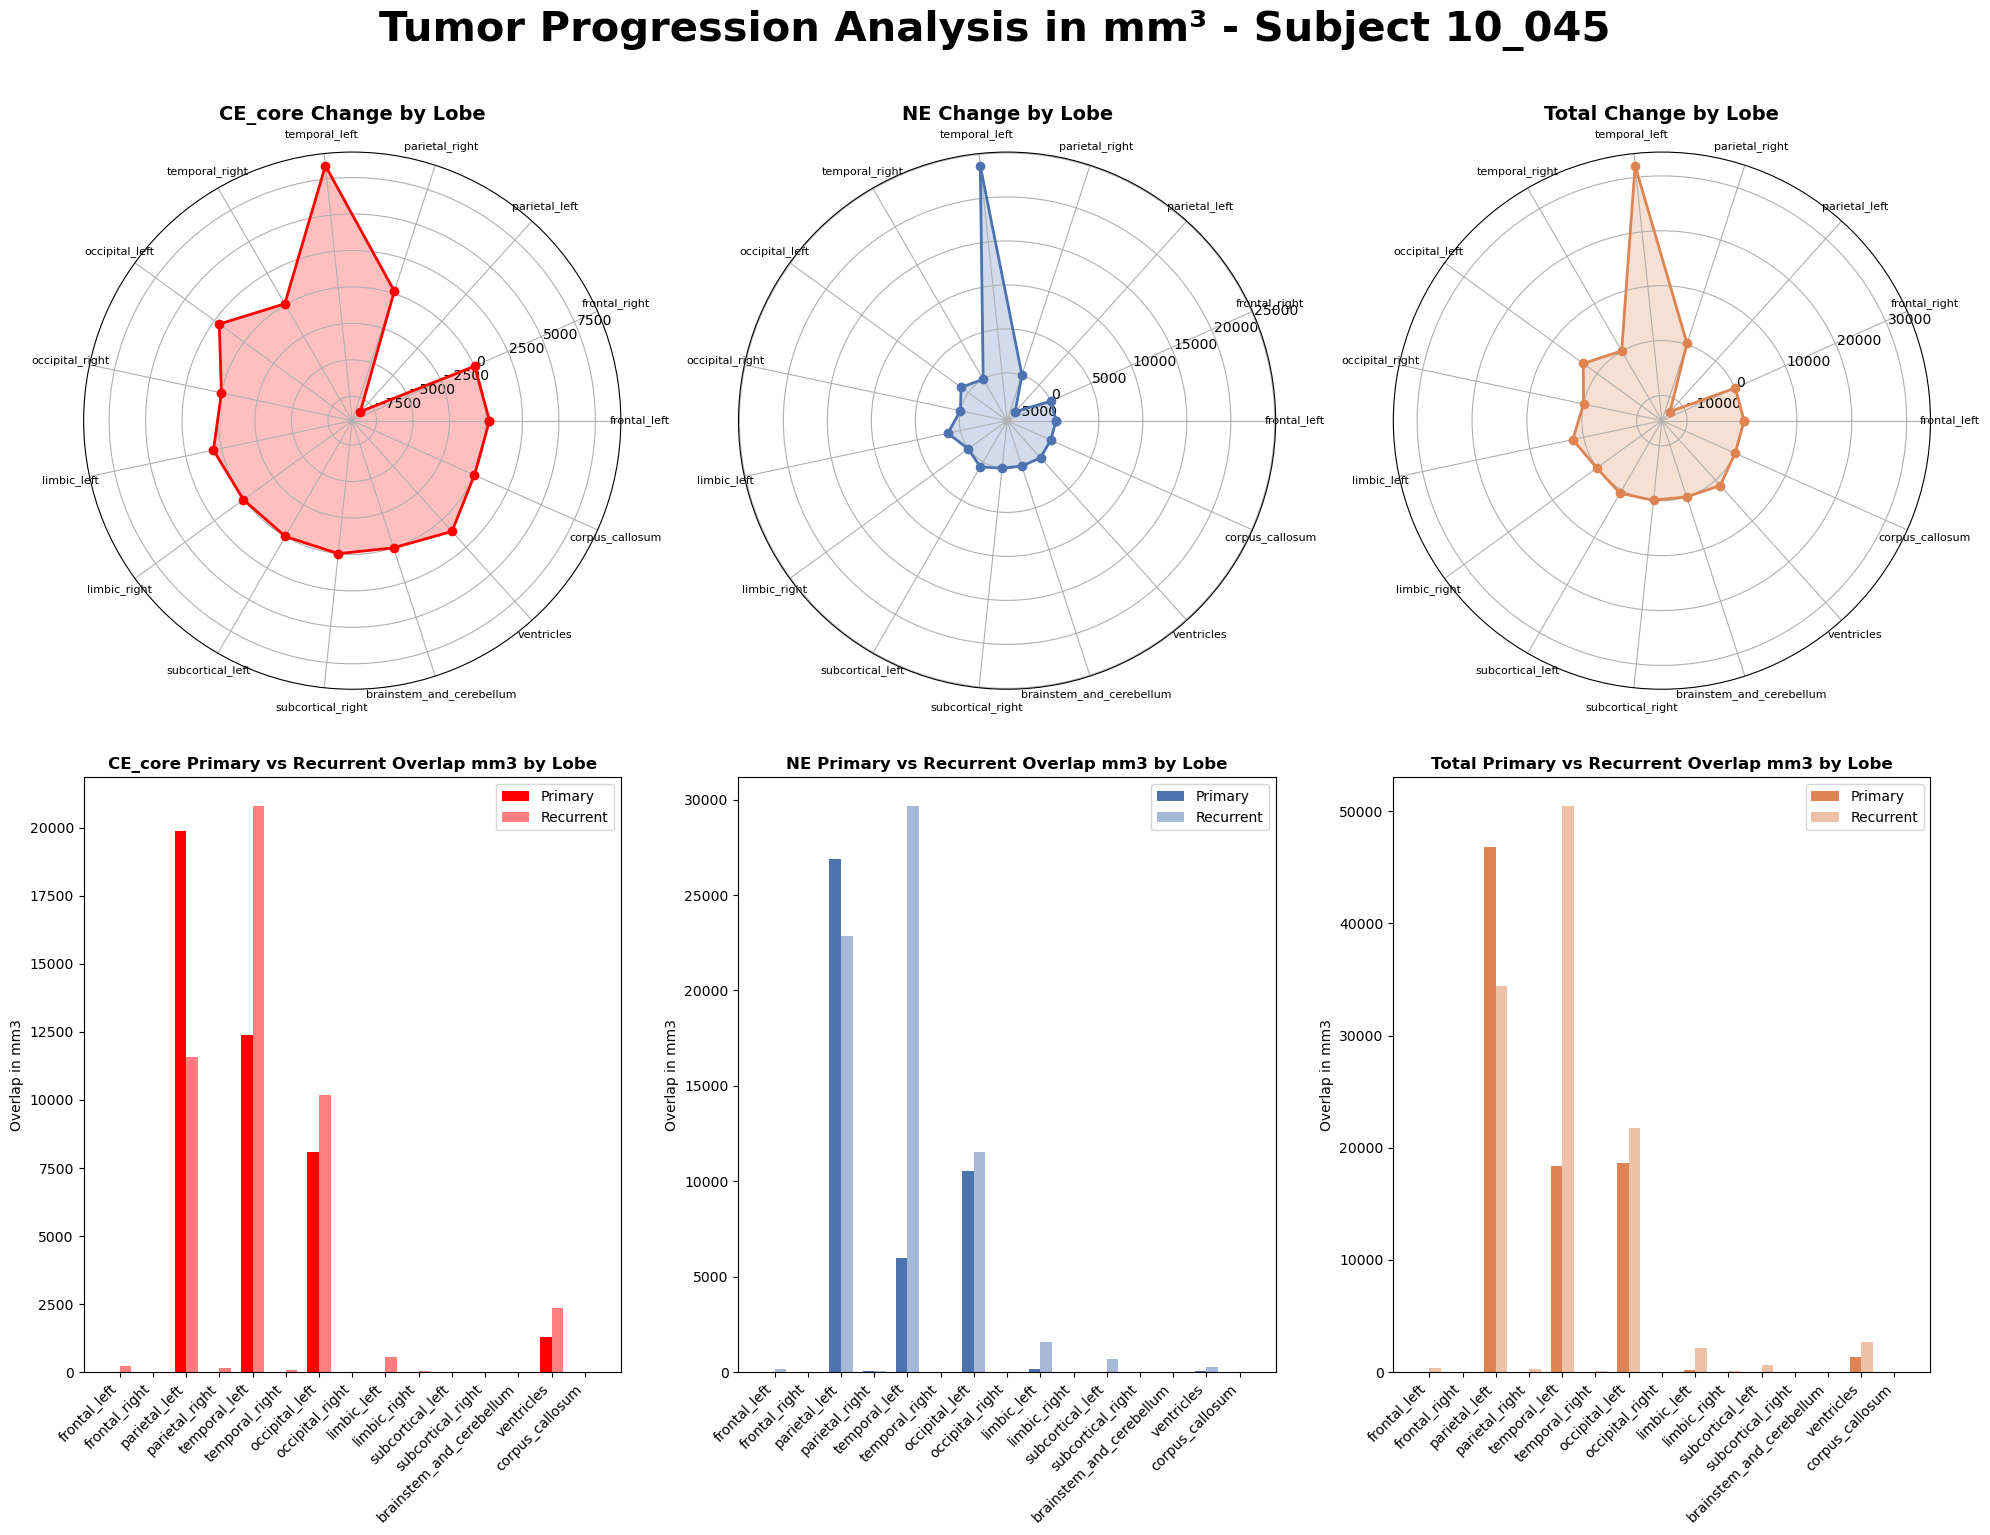


Overall Changes:
Lobe overall change (Euclidean distance): 34654.7618
Hemisphere overall change (Euclidean distance): 27443.5679

Detailed Changes by Component:

CE_core Changes:
  frontal_left: 242.0000
  frontal_right: 14.0000
  parietal_left: -8332.0000
  parietal_right: 167.0000
  temporal_left: 8409.0000
  temporal_right: 83.0000
  occipital_left: 2099.0000
  occipital_right: 0.0000
  limbic_left: 560.0000
  limbic_right: 53.0000
  subcortical_left: 0.0000
  subcortical_right: 0.0000
  brainstem_and_cerebellum: 0.0000
  ventricles: 1051.0000
  corpus_callosum: 0.0000

NE Changes:
  frontal_left: 148.0000
  frontal_right: 2.0000
  parietal_left: -4040.0000
  parietal_right: 42.0000
  temporal_left: 23711.0000
  temporal_right: -2.0000
  occipital_left: 1027.0000
  occipital_right: 0.0000
  limbic_left: 1455.0000
  limbic_right: 28.0000
  subcortical_left: 665.0000
  subcortical_right: 0.0000
  brainstem_and_cerebellum: 0.0000
  ventricles: 256.0000
  corpus_callosum: 0.0000

Total

In [47]:
def plot_tumor_progression_from_csv(csv_file, patient_num, exams_list_site):
    # Get patient info
    site, subj, date1, date2 = get_patient_info(patient_num, exams_list_site)
    subject_id = f"{site}_{subj}"
    
    # Read CSV file
    df = pd.read_csv(csv_file)
    
    # Get data for specific subject
    subject_data = df[df['Subject'] == subject_id]
    
    if len(subject_data) == 0:
        raise ValueError(f"No data found for subject {subject_id}")
    
    components = ['CE_core', 'NE', 'Total']
    
    # Define the correct list of lobes
    lobes = [
        'frontal_left', 'frontal_right',
        'parietal_left', 'parietal_right',
        'temporal_left', 'temporal_right',
        'occipital_left', 'occipital_right',
        'limbic_left', 'limbic_right',
        'subcortical_left', 'subcortical_right',
        'brainstem_and_cerebellum',
        'ventricles',
        'corpus_callosum'
    ]
    
    # Reconstruct results dictionary from DataFrame
    results = {
        'lobe_changes': {},
        'primary_lobe_overlaps': {},
        'recurrent_lobe_overlaps': {},
        'lobe_overall_change': float(subject_data['Lobe_Overall_Change'].iloc[0]),
        'hemisphere_overall_change': float(subject_data['Hemisphere_Overall_Change'].iloc[0])
    }
    
    # Fill in the dictionaries
    for lobe in lobes:
        results['lobe_changes'][lobe] = {}
        results['primary_lobe_overlaps'][lobe] = {}
        results['recurrent_lobe_overlaps'][lobe] = {}
        
        for component in components:
            change_col = f"{lobe}_{component}_Change"
            primary_col = f"{lobe}_{component}_Primary"
            recurrent_col = f"{lobe}_{component}_Recurrent"
            
            results['lobe_changes'][lobe][component] = float(subject_data[change_col].iloc[0])
            results['primary_lobe_overlaps'][lobe][component] = float(subject_data[primary_col].iloc[0])
            results['recurrent_lobe_overlaps'][lobe][component] = float(subject_data[recurrent_col].iloc[0])
    
   
    # Define colors for the components
    colors = {
        'CE_core': 'r',  # Red for CE_core
        'NE': sns.color_palette('deep')[0],  # Seaborn blue for NE
        'Total': sns.color_palette('deep')[1]  # Seaborn orange for Total
    }
    
    fig = plt.figure(figsize=(20, 15))
    fig.suptitle(f"Tumor Progression Analysis in mm³ - Subject {subject_id}", fontsize=30, weight='bold', y=1.02)
    
    for idx, component in enumerate(components):
        # Radar Chart
        ax1 = fig.add_subplot(2, 3, idx+1, polar=True)
        
        # Prepare data for plotting
        lobe_changes = [results['lobe_changes'][lobe][component] for lobe in lobes]
        
        # Number of variables
        num_vars = len(lobes)
        
        # Compute the angle for each axis
        angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
        angles += angles[:1]
        
        # Plot data
        lobe_changes += [lobe_changes[0]]  # Complete the loop
        ax1.plot(angles, lobe_changes, 'o-', linewidth=2, color=colors[component])
        
        # Fill the area
        ax1.fill(angles, lobe_changes, color=colors[component], alpha=0.25)
        
        # Set the labels
        ax1.set_xticks(angles[:-1])
        ax1.set_xticklabels(lobes, size=8)
        
        # Add title
        ax1.set_title(f"{component} Change by Lobe", size=14, weight='bold')
        
        # Bar Chart
        ax2 = fig.add_subplot(2, 3, idx+4)
        
        primary_overlaps = [results['primary_lobe_overlaps'][lobe][component] for lobe in lobes]
        recurrent_overlaps = [results['recurrent_lobe_overlaps'][lobe][component] for lobe in lobes]
        
        x = np.arange(len(lobes))
        width = 0.35
        
        # Primary overlaps: strong hue
        ax2.bar(x - width/2, primary_overlaps, width, label='Primary', alpha=1, color=colors[component])
        
        # Recurrent overlaps: softer hue (lower alpha)
        ax2.bar(x + width/2, recurrent_overlaps, width, label='Recurrent', alpha=0.5, color=colors[component])
        
        ax2.set_ylabel('Overlap in mm3')
        ax2.set_title(f'{component} Primary vs Recurrent Overlap mm3 by Lobe', size=12, weight='bold')
        ax2.set_xticks(x)
        ax2.set_xticklabels(lobes, rotation=45, ha='right')
        ax2.legend()
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.1)
    
    # Save the figure
    output_path = os.path.join(RESULTS, f'{subject_id}_tumor_progression_radial_barchart_WMlobes.png')
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Visualization saved as {output_path}")
    
    # Display the plot
    plt.show()
    
    # Additional textual summary
    print("\nOverall Changes:")
    print(f"Lobe overall change (Euclidean distance): {results['lobe_overall_change']:.4f}")
    print(f"Hemisphere overall change (Euclidean distance): {results['hemisphere_overall_change']:.4f}")
    
    print("\nDetailed Changes by Component:")
    for component in components:
        print(f"\n{component} Changes:")
        for lobe in lobes:
            change = results['lobe_changes'][lobe][component]
            print(f"  {lobe}: {change:.4f}")

# Example usage:
csv_file = os.path.join(RESULTS_overall, f'{site}_tumor_overlap_WMlobes_NEW_SR.csv')
plot_tumor_progression_from_csv(csv_file, patient, exams_list_site=exams_list_site)
#plot_tumor_progression_from_csv(csv_file, patient_num=41, exams_list_site=exams_list_site)
